# **STEP 1: PROBLEM STATEMENT**

Fintech applications rely heavily on user engagement and retention to drive growth and profitability. However, many users drop off shortly after initial app use, and understanding the underlying causes of churn remains a challenge. The goal of this project is to analyze user interaction data from a fintech app to uncover behavioral patterns, segment users based on their app usage, identify drop-off points in the user journey, and build predictive models to forecast user churn.

By leveraging techniques such as behavior segmentation, funnel analysis, and machine learning classification, the project aims to generate actionable product insights that can inform strategies for improving user retention and engagement.

# **STEP 1.1: EXPECTED OUTCOME**

The expected outcome of this project is to deliver actionable insights that help the business improve user retention and engagement within the fintech app. By analyzing user behavior, segmenting customers, and predicting churn, the project will support data-driven decisions to optimize product features, reduce drop-offs, and implement targeted strategies—such as timely notifications and improved onboarding—that enhance the overall user experience and drive business growth.

# **STEP 1.2: OBJECTIVE**

The objective of this fintech app user behavior analysis project is to analyze user interaction patterns and develop a predictive model to identify users at risk of churn, enabling data-driven strategies to enhance retention and engagement.

1. Improve User Retention: Identify behavioral trends associated with churn to implement targeted interventions that encourage continued app usage.

2. Enhance Customer Segmentation: Use clustering techniques to group users based on engagement levels, supporting personalized marketing and product strategies.

3. Optimize Product Experience: Pinpoint drop-off points and friction in the user journey to inform UX/UI improvements and feature enhancements.

4. Support Data-Driven Decisions: Provide actionable insights for product and growth teams to prioritize retention-focused initiatives backed by user data.




# **STEP 2: LOADING NECESSARY LIBRARIES**  

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# **STEP 2.1: LOADING THE DATA**

The [app usage data](https://www.kaggle.com/datasets/raghavraipuria/fintech-data) is only from the user's first day in the app. This limitation exists because users can enjoy a 24-hour free trial of the premium features, and the company wants to target them with new offers shortly after the trial is over.

In [54]:
app_data_df = pd.read_csv('appdata.csv')
app_data_df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


# **STEP 3: DATA PREPROCESSING**

In [55]:
app_data_df.shape

(50000, 12)

In [56]:
app_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   user                  50000 non-null  int64 
 1   first_open            50000 non-null  object
 2   dayofweek             50000 non-null  int64 
 3   hour                  50000 non-null  object
 4   age                   50000 non-null  int64 
 5   screen_list           50000 non-null  object
 6   numscreens            50000 non-null  int64 
 7   minigame              50000 non-null  int64 
 8   used_premium_feature  50000 non-null  int64 
 9   enrolled              50000 non-null  int64 
 10  enrolled_date         31074 non-null  object
 11  liked                 50000 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 4.6+ MB


In [57]:
# Convert dates
app_data_df['first_open'] = pd.to_datetime(app_data_df['first_open'], errors='coerce')
app_data_df['enrolled_date'] = pd.to_datetime(app_data_df['enrolled_date'], errors='coerce')

In [58]:
app_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user                  50000 non-null  int64         
 1   first_open            50000 non-null  datetime64[ns]
 2   dayofweek             50000 non-null  int64         
 3   hour                  50000 non-null  object        
 4   age                   50000 non-null  int64         
 5   screen_list           50000 non-null  object        
 6   numscreens            50000 non-null  int64         
 7   minigame              50000 non-null  int64         
 8   used_premium_feature  50000 non-null  int64         
 9   enrolled              50000 non-null  int64         
 10  enrolled_date         31074 non-null  datetime64[ns]
 11  liked                 50000 non-null  int64         
dtypes: datetime64[ns](2), int64(8), object(2)
memory usage: 4.6+ MB


In [59]:
# Create time delta (time to enroll)
app_data_df['time_to_enroll'] = (app_data_df['enrolled_date'] - app_data_df['first_open']).dt.total_seconds() / 3600  # in hours


In [60]:
# Clean screen_list to count screens
app_data_df['screen_list'] = app_data_df['screen_list'].astype(str)
app_data_df['screen_count'] = app_data_df['screen_list'].apply(lambda x: len(x.split(',')))

In [61]:
app_data_df['screen_count'].unique()

array([13, 11,  3, 17, 19, 27,  9,  4,  5, 15,  6, 14,  7, 22,  8, 26,  1,
       24, 10, 23, 40, 16, 18, 25, 37, 21, 20, 12, 32, 29, 50, 31,  2, 28,
       34, 33, 30, 47, 42, 38, 36, 35, 49, 41, 39, 43, 53, 44, 48, 46, 64,
       79, 52, 45, 62])

In [62]:
app_data_df.isnull().sum()

,0
user,0
first_open,0
dayofweek,0
hour,0
age,0
screen_list,0
numscreens,0
minigame,0
used_premium_feature,0
enrolled,0


Both enrolled_date and time_to_enroll have 18,926 null values, it  means that these users never enrolled after opening the app, so their enrollment date is missing, and thus the time it took to enroll can’t be calculated.

In [63]:
app_data_df['time_to_enroll'].fillna(-1, inplace=True)

I have sets uncalculated times to -1 to clearly mark them as "not enrolled".

In [64]:
app_data_df.isnull().sum()

,0
user,0
first_open,0
dayofweek,0
hour,0
age,0
screen_list,0
numscreens,0
minigame,0
used_premium_feature,0
enrolled,0


In [65]:
# Count of duplicate users
num_duplicates = app_data_df['user'].duplicated().sum()
print(f"Number of duplicate users: {num_duplicates}")

Number of duplicate users: 126


**So I'll drop the duplicates**

In [66]:
app_data_df.drop_duplicates(subset='user', keep='first', inplace=True)

In [67]:
# Count of duplicate users
num_duplicates = app_data_df['user'].duplicated().sum()
print(f"Number of duplicate users: {num_duplicates}")

Number of duplicate users: 0


In [68]:
app_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49874 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user                  49874 non-null  int64         
 1   first_open            49874 non-null  datetime64[ns]
 2   dayofweek             49874 non-null  int64         
 3   hour                  49874 non-null  object        
 4   age                   49874 non-null  int64         
 5   screen_list           49874 non-null  object        
 6   numscreens            49874 non-null  int64         
 7   minigame              49874 non-null  int64         
 8   used_premium_feature  49874 non-null  int64         
 9   enrolled              49874 non-null  int64         
 10  enrolled_date         31004 non-null  datetime64[ns]
 11  liked                 49874 non-null  int64         
 12  time_to_enroll        49874 non-null  float64       
 13  screen_count         

**converting hour to numeric hour format (e.g., 2 for 2 AM).**

In [69]:
app_data_df['hour'] = pd.to_datetime(app_data_df['hour'].str.strip(), format='%H:%M:%S', errors='coerce').dt.hour

In [70]:
app_data_df['churned'] = app_data_df['enrolled'].apply(lambda x: 0 if x == 1 else 1)

**VISUALIZE**

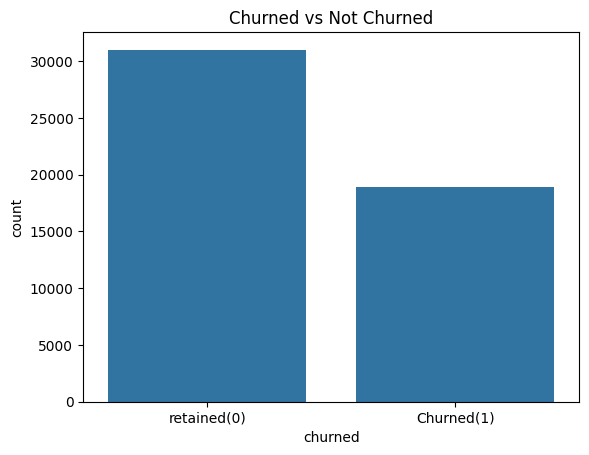

In [71]:
sns.countplot(x='churned', data=app_data_df)
plt.title("Churned vs Not Churned")
plt.xticks([0, 1], ['retained(0)', 'Churned(1)'])
plt.show()


- 0 = retained
- 1 = did not enroll(churned)

The number of people who enrolled(retained) is more than those who churned.

**Distribution of Number of Screens**

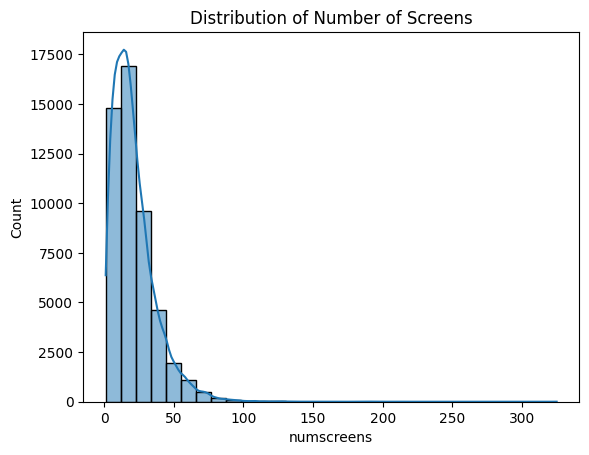

In [72]:
sns.histplot(app_data_df['numscreens'], bins=30, kde=True)
plt.title("Distribution of Number of Screens")
plt.show()

**INTERPRETATION**

- The distribution is right-skewed, meaning most users interacted with a relatively small number of screens.

**Visualizing distribution of Liked**

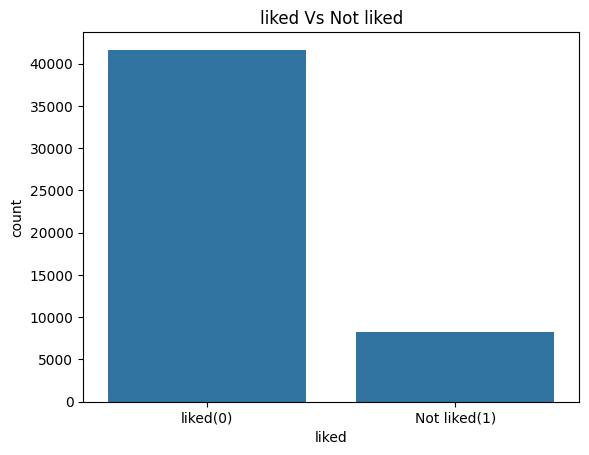

In [73]:
sns.countplot(x='liked', data=app_data_df)
plt.title("liked Vs Not liked")
plt.xticks([0, 1], ['liked(0)', 'Not liked(1)'])
plt.show()

**INTERPRETATION**

- The graph shows that the number of users who liked the app (liked = 0) is higher than those who did not like it (liked = 1).
- This indicates that a majority of users had a positive impression of the app. It suggests that users generally found the app satisfactory or engaging.

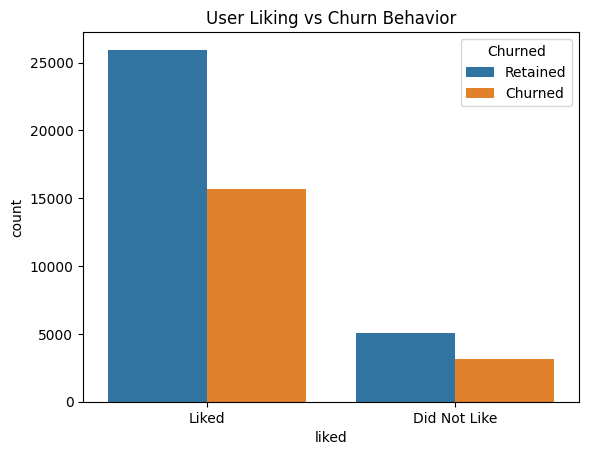

In [74]:
sns.countplot(x='liked', hue='churned', data=app_data_df)
plt.title("User Liking vs Churn Behavior")
plt.xticks([0, 1], ['Liked', 'Did Not Like'])
plt.legend(title="Churned", labels=["Retained", "Churned"])
plt.show()

**INTERPRETATION**

- Majority of those who enrolled like the app.


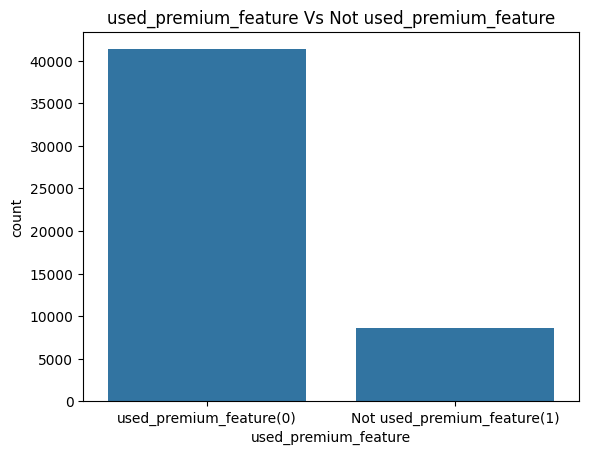

In [75]:
sns.countplot(x='used_premium_feature', data=app_data_df)
plt.title("used_premium_feature Vs Not used_premium_feature")
plt.xticks([0, 1], ['used_premium_feature(0)', 'Not used_premium_feature(1)'])
plt.show()

**INTERPRETATION**

- The majority of users used the premium feature (used_premium_feature = 0).


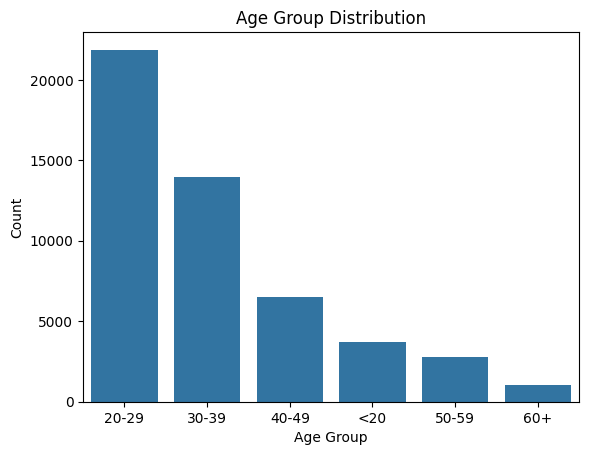

In [76]:
# Group ages into age groups
app_data_df['age_group'] = pd.cut(app_data_df['age'],
                                  bins=[0, 20, 30, 40, 50, 60, 100],
                                  labels=['<20', '20-29', '30-39', '40-49', '50-59', '60+'],
                                  right=False)

# Visualize the distribution of age groups
sns.countplot(x='age_group', data=app_data_df, order=app_data_df['age_group'].value_counts().index)
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

**INTERPRETATION**

- The app is mostly used by younger adults (20–39), which might be due design, content, and marketing strategies.
- Older users are underrepresented could be due to usability issues, lack of relevance, or targeting.

**Correlation Heatmap (Numerical Columns Only)**

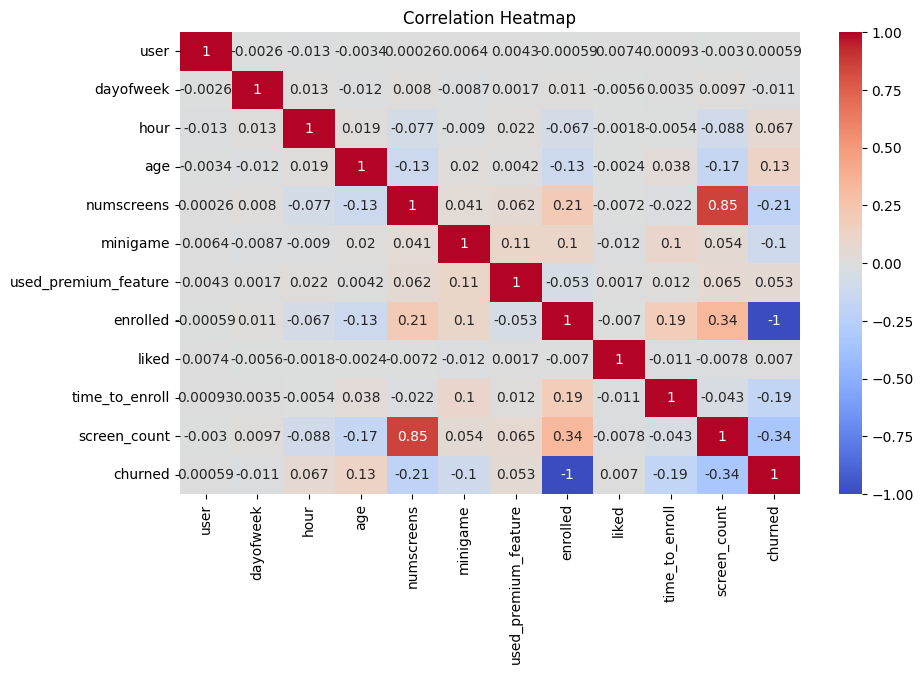

In [77]:
numeric_cols = app_data_df.select_dtypes(include='number')
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# **STEP 4: Behavior Segmentation with K-Means**


In [78]:
# Features for segmentation
features = app_data_df[['screen_count', 'minigame', 'used_premium_feature', 'numscreens', 'liked','dayofweek']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [79]:
# K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
app_data_df['segment'] = kmeans.fit_predict(X_scaled)

In [80]:
# PCA for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
app_data_df['pca1'], app_data_df['pca2'] = components[:, 0], components[:, 1]

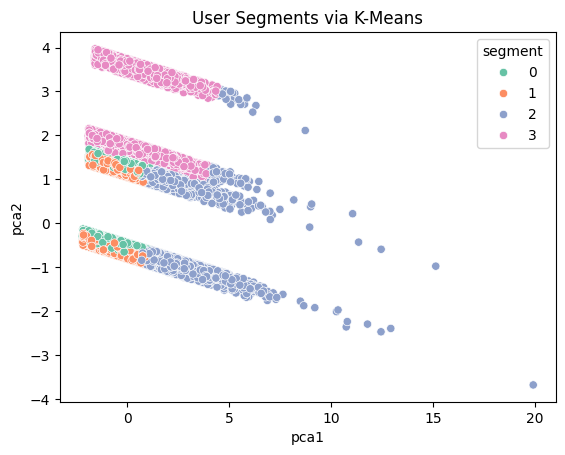

In [81]:
# Visualize clusters
sns.scatterplot(data=app_data_df, x='pca1', y='pca2', hue='segment', palette='Set2')
plt.title('User Segments via K-Means')
plt.show()

# **STEP 5: Retention & Funnel Analysis**

**Retention** refers to how well an app keeps its users over time. A retained user is someone who comes back and continues using the app after their first interaction for example, 7 days or 14 days later.

**Funnel analysis** is a method to visualize and measure how users move through key stages (steps) in an app, from signing up to completing an important action (like making a transaction). It helps identify where users drop off.



In [82]:
app_data_df['retention_days'] = (app_data_df['enrolled_date'] - app_data_df['first_open']).dt.days
app_data_df['retained_7days'] = app_data_df['retention_days'] <= 7

A user is considered retained if they enrolled within 7 days of first opening the app

**Creating a Funnel**

**funnel stages:**

Step 1: First Opened App

Step 2: Enrolled

Step 3: Used Premium Feature

Step 4: Liked the App

I will count how many users completed each stage:

In [83]:
step1 = len(app_data_df)
step2 = app_data_df['enrolled'].sum()
step3 = app_data_df['used_premium_feature'].sum()
step4 = app_data_df['liked'].sum()


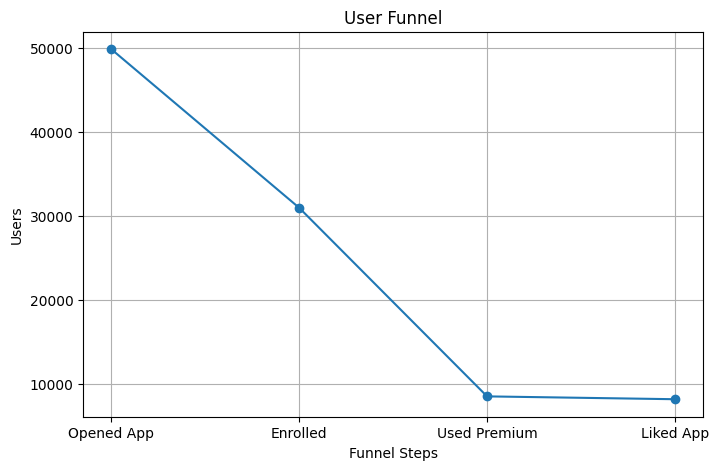

In [84]:
import matplotlib.pyplot as plt

steps = ['Opened App', 'Enrolled', 'Used Premium', 'Liked App']
values = [step1, step2, step3, step4]

plt.figure(figsize=(8, 5))
plt.plot(steps, values, marker='o')
plt.title('User Funnel')
plt.xlabel('Funnel Steps')
plt.ylabel('Users')
plt.grid(True)
plt.show()


**INTERPRETATION**

- Opened App (~50,000 users)
- Enrolled (~31,000 users)
- Used Premium (~9,000 users)
- Liked App (~8,000 users)

There are significant drop-offs at each step:
- 38% drop after opening app to enrollment.
- 71% drop from enrolled to premium use.
- Minor drop from premium use to liking the app (~11%).

Largest friction point: Getting users to use the premium feature after enrolling.

"Liking" behavior is fairly high once premium is used—indicating satisfaction among converted users.



# **STEP 6: Churn Prediction**

**Churn** refers to users who stop using the app after a certain period. In a fintech app, a churned user might be someone who registered but didn’t engage with key features or didn’t return within 7, 14, or 30 days.

**Preparing Features for Modeling**

In [85]:
app_data_df['churned'] = app_data_df['enrolled'].apply(lambda x: 0 if x == 1 else 1)


In [86]:
app_data_df['churned'].value_counts()


,count
churned,
0,31004
1,18870


enroll = 0
did not enroll = 1

In [87]:
features = ['numscreens', 'screen_count', 'hour', 'minigame',
            'used_premium_feature', 'liked', 'dayofweek']


In [88]:
X = app_data_df[features]
y = app_data_df['churned']


In [89]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [90]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


 **Train a Classification Model**

In [91]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("🔹 Logistic Regression\n", classification_report(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # RF doesn't need scaled input
y_pred_rf = rf.predict(X_test)
print("🔹 Random Forest\n", classification_report(y_test, y_pred_rf))

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("🔹 XGBoost\n", classification_report(y_test, y_pred_xgb))


🔹 Logistic Regression
               precision    recall  f1-score   support

           0       0.73      0.83      0.77      6192
           1       0.64      0.48      0.55      3783

    accuracy                           0.70      9975
   macro avg       0.68      0.66      0.66      9975
weighted avg       0.69      0.70      0.69      9975

🔹 Random Forest
               precision    recall  f1-score   support

           0       0.72      0.77      0.74      6192
           1       0.57      0.50      0.53      3783

    accuracy                           0.67      9975
   macro avg       0.64      0.63      0.64      9975
weighted avg       0.66      0.67      0.66      9975

🔹 XGBoost
               precision    recall  f1-score   support

           0       0.73      0.81      0.77      6192
           1       0.62      0.51      0.56      3783

    accuracy                           0.70      9975
   macro avg       0.68      0.66      0.67      9975
weighted avg       0.69

# **STEP 7: MODEL SELECTION**

Best Model is XGBoost because it has:
- Highest performance on positive class (class 1).
- Best weighted F1-score.
- Best balance between precision and recall.

# **STEP 8: Feature Importance:**  
- To Understand which behaviors contribute most to churn.

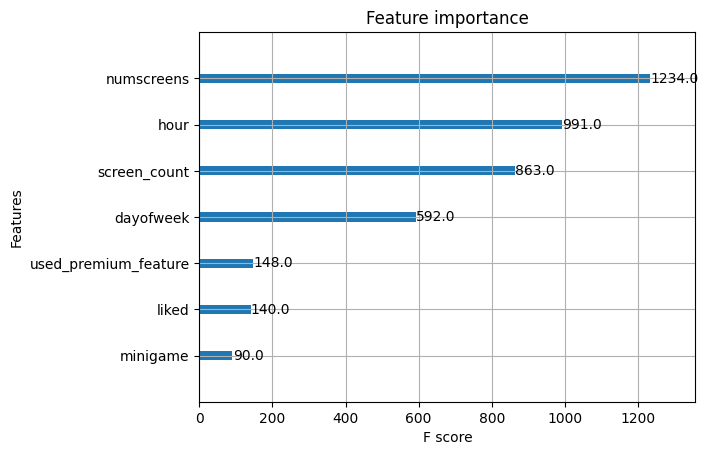

In [92]:
from xgboost import plot_importance

plot_importance(xgb)
plt.show()


**INTERPRETATION**

- The user's screen usage behavior (numscreens, screen_count ) is most predictive of the target variable. Behavioral features outweigh categorical ones like liked or used_premium_feature.



# **STEP 9: CONCLUSION**

- The analysis reveals valuable insights into user behavior and app performance. A significant number of users (18,926) opened the app but never enrolled, indicating a potential barrier in the onboarding process. However, the majority of users who opened the app did enroll, showing overall interest. The user base is primarily composed of younger adults (ages 20–39), suggesting effective targeting but also highlighting an opportunity to improve accessibility or appeal to older demographics.

- Screen interaction behavior especially numscreens and screen_count emerged as the strongest predictors of enrollment, demonstrating that user engagement is a key indicator of retention. Most users liked the app and used premium features, but a notable drop-off (71%) occurred after enrollment when transitioning to premium usage. This points to the need for optimizing the premium experience, perhaps through better value communication or trial incentives.

- From a modeling perspective, XGBoost outperformed other classifiers, providing the best balance of precision, recall, and F1-score. It effectively identifies users at risk of churn, making it a powerful tool for targeted retention strategies.

# **STEP 10: BUSINESS INSIGHTS** - **Strategies to Improve Conversion and Reduce Churn**

Based on the findings, the following strategic areas are key to improving user engagement, increasing conversions, and reducing churn:

1. **Smoothing the Path from Enrollment to Premium Use**

There is a 71% drop-off between users who enroll and those who go on to use premium features. This suggests friction or lack of motivation at this stage. To address this:

- Introduce guided tours or onboarding nudges that highlight the value of premium features.
- Offer limited-time free trials or discounts to reduce hesitation.
- Use in-app messaging or push notifications to remind enrolled users of the benefits and prompt exploration of premium content.

2. **Enhancing Onboarding for New Users**

With nearly 19,000 users not enrolling after opening the app, it's clear that the onboarding process needs improvement:

- Simplify the sign-up/enrollment flow to minimize drop-off due to complexity or time delays.
- Present a clear value proposition early in the user journey.
- Include interactive onboarding that walks users through key features and encourages early engagement.

3. **Expanding Engagement Strategies to Underserved Age Groups**

The data shows the app is predominantly used by users aged 20–39, while older age groups are underrepresented:

- Conduct usability testing with older demographics to identify barriers (e.g., font size, navigation clarity).
- Adapt content, design, and marketing messages to resonate with broader age groups.
- Partner with organizations that reach older adults to create awareness campaigns or targeted onboarding incentives.

4. **Leveraging Behavioral Signals for Personalized Marketing and Intervention**

Features such as numscreens and screen_count are strong predictors of user retention. This opens up opportunities for behavior-based segmentation:

- Use real-time analytics to identify disengaged users early and trigger targeted interventions (e.g., reminders, rewards).
- Customize the app experience using personalized content or feature recommendations based on user behavior.
- Deploy machine learning models like XGBoost to score users by churn risk and prioritize retention efforts accordingly.
